# The purpose of this notebook is to develop a good framework for model testing

In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
from src.Trait_SIn import SIn
import matplotlib.pyplot as plt

#ignore warnings to avoid flooding notebook output
import warnings
warnings.filterwarnings('ignore')

Starting 100000 processes with 8 cores
count     62785.000000
mean      14747.310455
std       85827.501950
min          12.398724
25%         136.952536
50%         152.663121
75%         152.832958
max      974516.105742
Name: chi, dtype: float64


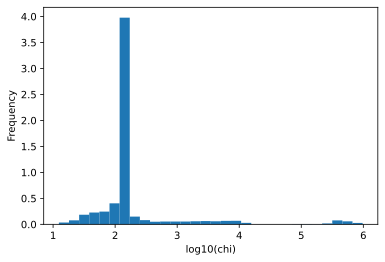

In [2]:
#we will first do our fittings with some preformated data
df = pd.read_csv('data/testdat.csv')
df = df.set_index('organism')
#initialize model framework
modframe = SIn(df,Infection_states=0)
#use latin hypercube sampling to get some good inits
inits=modframe.search_inits(samples=100000,cpu_cores=8,mu=(6,4,True),phi=(8,4,True),beta=(30,15,False))
a=np.log10(inits['chi']).plot.hist(bins=30,density=True)
a.set_xlabel('log10(chi)')
print(inits['chi'].describe())

In [3]:
initial_values = inits[inits['chi'] < 152.660533].sample(n=100)
posterior = modframe.MCMC(initial_values,iterations = 10000, cpu_cores=8)

Starting 100 processes with 8 cores

Fitting Report
parameter: mu
	median = 9.861e-08,Standard deviation = 3.320e+22
parameter: phi
	median = 1.007e-08,Standard deviation = 5.747e-07
parameter: beta
	median = 2.339e+01,Standard deviation = 7.896e+02


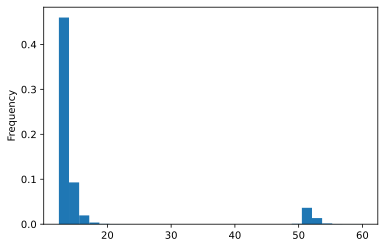

In [14]:
a=posterior['chi'].plot.hist(bins=30,density=True)

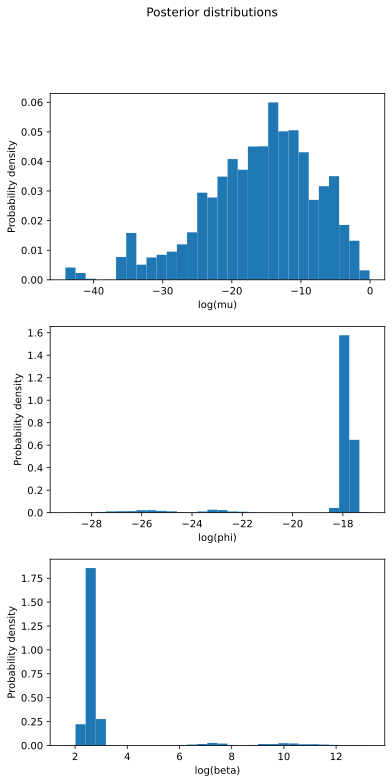

In [4]:
pnames = modframe.get_pnames()
dim = len(pnames)
f,ax = plt.subplots(dim,figsize=[dim*2,dim*4])
ax = ax.flatten()
for (a,p,i) in zip(ax,pnames,range(len(pnames))):
    a.hist(np.log(posterior[p]),30,density=True)
    a.set_xlabel('log('+p+')')
    a.set_ylabel('Probability density')
f.suptitle('Posterior distributions')
f.subplots_adjust(hspace=0.25,wspace=0.25)    

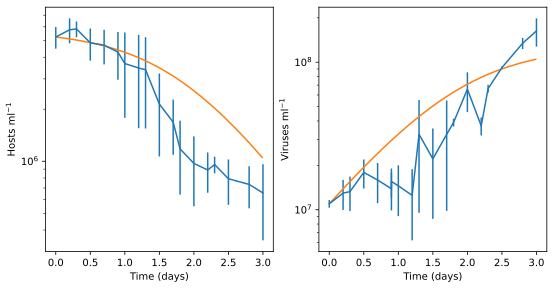

In [6]:
f,ax = modframe.plot()

In [11]:
modframe

Number of Infection States = 0
Parameters:
	mu = 9.861384997909844e-08
	phi = 1.0065852011044831e-08
	beta = 23.392921799222037

In [ ]:
modframe = SIn(df,Infection_states=1)
inits=modframe.search_inits(samples=100000,cpu_cores=8,mu=(6,4,True),phi=(8,4,True),beta=(30,15,False))